# Example 9 Grid-MPO dynamics(relaxation) in H2CO molecute

| run type      | wavefunction | backend | Basis  | steps |
| ---           | ---          | ---     | ---    | ---   |
| improved relaxation | MPS-SM | jax   | HO-DVR | 20    |

## 1. Import modules

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
from discvar import HarmonicOscillator

from pytdscf import Model, Simulator
from pytdscf.dvr_operator_cls import (
    TensorOperator,
    construct_kinetic_operator,
    construct_nMR_recursive,
    database_to_dataframe,
)
from pytdscf.hamiltonian_cls import TensorHamiltonian

np.set_printoptions(precision=12)

## 2. Set DVR primitive basis

- MPS-SM wavefunction
$$
|\Psi_{\rm{MPS-SM}}\rangle = \sum_{\mathbf \{j\}}\sum_{\mathbf \{\tau\}}
a\substack{j_1 \\ 1\tau_1}a\substack{j_2 \\ \tau_1\tau_2} \cdots a\substack{j_f \\ \tau_{f-1}1}
|\chi_{j_1}^{(1)}(q_1)\rangle|\chi_{j_2}^{(2)}(q_2)\rangle
\cdots|\chi_{j_f}^{(f)}(q_f)\rangle
$$

Here, select $\{\chi_{j_p}^{(p)}(q_p)\}$ as Harmonic Oscillator DVR-basis

**NOTE**
- DVR primitive basis must be consisitent with pre-calulated PES grids

In [2]:
freqs = [1186.325, 1252.832, 1514.908, 1831.831, 2863.96, 2916.722]  # cm-1
ngrids = [7, 7, 7, 7, 7, 7]  # 7^6 grids
prim_info = [
    [
        HarmonicOscillator(ngrid, omega, units="cm1")
        for ngrid, omega in zip(ngrids, freqs, strict=False)
    ]
]  # number of state is 1 --> S0

## 3. Set Hamiltonian (MPO)

Here, one uses pre-calculated 2-Mode Representation PES and DMS database

### 3-1 Read from the Database and merge into one MPO
It takes a few minutes...
If one compresses MPO by SVD, assign contribution rate under 1.0, (e.g., `rate=0.999999`)

Not only n-Mode Representation MPO, but also full-dimensional MPO is supported. Use
- `pytdscf.dvr_operator_cls.construct_fulldimensional`

If one use not a Database but a given analytical function, one can use
- `pytdscf.dvr_operator_cls.PotentialFunction`

and
- `func` option


In [3]:
database = "H2CO_7grids.db"  # This must be prepared in advance
df = database_to_dataframe(database, reference_grids=[3, 3, 3, 3, 3, 3])
df

id,grids,grids_db,dofs,dofs_db,nMR,energy,dipole,distance
i64,list[i64],str,list[i64],str,i64,f64,list[f64],i64
1,"[0, 3, … 3]","""|0 3 3 3 3 3""",[0],"""|0""",1,-114.474833,"[0.125334, -0.000254, -2.149885]",3
2,"[1, 3, … 3]","""|1 3 3 3 3 3""",[0],"""|0""",1,-114.487242,"[0.078286, -0.000127, -2.255444]",2
3,"[2, 3, … 3]","""|2 3 3 3 3 3""",[0],"""|0""",1,-114.493254,"[0.037847, -0.000051, -2.309838]",1
4,"[3, 3, … 3]","""|3 3 3 3 3 3""",[0],"""|0""",0,-114.495088,"[0.0, 0.0, -2.326893]",0
5,"[4, 3, … 3]","""|4 3 3 3 3 3""",[0],"""|0""",1,-114.493254,"[-0.037847, 0.000025, -2.309838]",1
…,…,…,…,…,…,…,…,…
773,"[3, 3, … 2]","""|3 3 3 3 6 2""","[4, 5]","""|4 5""",2,-114.408589,"[0.0, 0.072999, -2.61139]",4
774,"[3, 3, … 3]","""|3 3 3 3 6 3""","[4, 5]","""|4 5""",1,-114.423631,"[-0.0, 0.000153, -2.626234]",3
775,"[3, 3, … 4]","""|3 3 3 3 6 4""","[4, 5]","""|4 5""",2,-114.408639,"[-0.0, -0.072669, -2.611594]",4


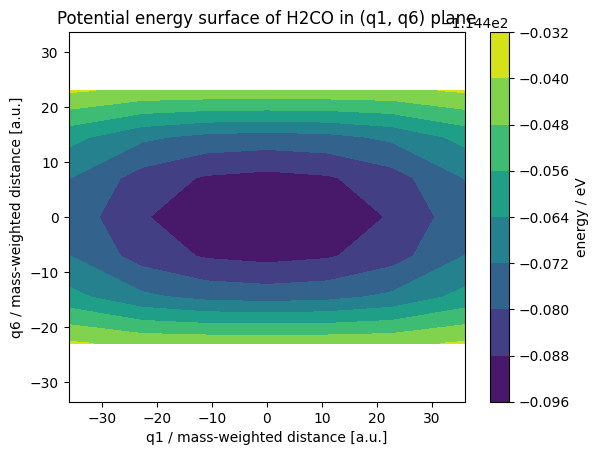

In [4]:
q6, q1 = np.meshgrid(prim_info[0][5].get_grids(), prim_info[0][0].get_grids())
energy = (
    df.filter(pl.col("dofs_db") == "|0 5").sort("grids_db")["energy"].to_numpy()
)
plt.contourf(q1, q6, energy.reshape(7, 7))
plt.colorbar(label="energy / eV")
plt.xlabel("q1 / mass-weighted distance [a.u.]")
plt.ylabel("q6 / mass-weighted distance [a.u.]")
plt.title("Potential energy surface of H2CO in (q1, q6) plane")
plt.axis("equal")
plt.show()

**Check MPO on $J=(j_1, j_2, \ldots, j_f)$ index**

In [5]:
mpo = construct_nMR_recursive(prim_info[0], nMR=2, df=df, rate=0.99999999)
dum = None
J = [3, 3, 3, 3, 3, 3]
for j, core in zip(J, mpo, strict=False):
    if dum is None:
        dum = core[:, j, :]
    else:
        dum = np.einsum("ij,jk->ik", dum, core[:, j, :])
print(dum)  # Better to be 0.0

[[1.307280831011e-08]]


### 3-2 Build kinetic term

In [6]:
kinetic = [[construct_kinetic_operator(dvr_prims=prim_info[0])]]

### 3-3 Set all operators

In [7]:
ndof = len(ngrids)
potential = [[{tuple([k for k in range(ndof)]): TensorOperator(mpo=mpo)}]]
hamiltonian = TensorHamiltonian(ndof, potential, kinetic=kinetic, backend="jax")
operators = {"hamiltonian": hamiltonian}

## 4. Set wave function (MPS) and All Model

- `m_aux_max` is the MPS bond dimension (maximum of auxiliary index $\tau_p$)
- `init_weight_ESTATE` is the initial electronic state weight. In this case, one is considering a single estate, thus this is ignored.
- `init_weight_VIB_GS` is the initial vibrational ground state weight. `1.0` means the MPS of GS grid-pair which denotes the bottom of the potential energy surface is 1.0 and other terms are 0.0.



In [8]:
model = Model(basis, operators)
nstate = 1
model.m_aux_max = 10
model.init_weight_VIB_GS = 1.0

## 5. Execute Calculation

- time step width is defined by `stepsize`=0.1 fs

F.Y.I., See also [documentation](https://qclovers.github.io/PyTDSCF/pytdscf.html#pytdscf.const_cls.Const.set_runtype)


**NOTE**
- Runtype cannnot rebind. If you want to change runtype, you should restart kernel.

In [9]:
jobname = f"h2co_7_grids_{model.m_aux_max}m"
simulator = Simulator(jobname, model, ci_type="MPS", backend="jax", verbose=4)
simulator.relax(maxstep=10, stepsize=0.1)

2024-10-26 20:21:51,163 - INFO:main.pytdscf._const_cls - 
     ____     __________   .____ ____   _____
    / _  |   /__  __/ _ \ / ___ / _  \ / ___/
   / /_) /_  __/ / / / ||/ /__ / / )_// /__
  /  ___/ / / / / / / / |.__  / |  __/ ___/
 /  /  / /_/ / / / /_/ /___/ /| \_/ / /
/__/   \__, /_/ /_____/_____/ \____/_/
      /____/

2024-10-26 20:21:51,164 - INFO:main.pytdscf._const_cls - Log file is ./h2co_7_grids_10m_relax/main.log
2024-10-26 20:21:51,164 - INFO:main.pytdscf.simulator_cls - Set integral of DVR basis
2024-10-26 20:21:51,167 - INFO:main.pytdscf.simulator_cls - Set initial wave function (DVR basis)
2024-10-26 20:21:51,167 - INFO:main.pytdscf.simulator_cls - Prepare MPS w.f.
2024-10-26 20:21:51,168 - INFO:main.pytdscf._mps_cls - Initial MPS: 0-state with weights 1.0
2024-10-26 20:21:51,168 - INFO:main.pytdscf._mps_cls - Initial MPS: 0-state 0-mode with weight [1. 0. 0. 0. 0. 0. 0.]
2024-10-26 20:21:51,168 - INFO:main.pytdscf._mps_cls - Initial MPS: 0-state 1-mode with weight

(0.026051624508132566, <pytdscf.wavefunction.WFunc at 0x11cbf41a0>)

## 6. Check Log file
See f`{jobname}_relax/main.log`, which is defined by constructer of `Simulator`

In [10]:
!tail h2co_7_grids_10m_relax/main.log

| pop 1.0000 | ene[eV]:  0.7089008 | time[fs]:    0.400 | elapsed[sec]:     1.00 | ci:  1.0  (ci_exp:  0.8|ci_rnm:  0.2|ci_etc:  0.0 d) |    0 MFLOPS (  0.0 s) 
| pop 1.0000 | ene[eV]:  0.7089008 | time[fs]:    0.500 | elapsed[sec]:     1.04 | ci:  1.0  (ci_exp:  0.8|ci_rnm:  0.2|ci_etc:  0.0 d) |    0 MFLOPS (  0.0 s) 
| pop 1.0000 | ene[eV]:  0.7089008 | time[fs]:    0.600 | elapsed[sec]:     1.08 | ci:  1.1  (ci_exp:  0.8|ci_rnm:  0.2|ci_etc:  0.0 d) |    0 MFLOPS (  0.0 s) 
| pop 1.0000 | ene[eV]:  0.7089008 | time[fs]:    0.700 | elapsed[sec]:     1.12 | ci:  1.1  (ci_exp:  0.9|ci_rnm:  0.2|ci_etc:  0.0 d) |    0 MFLOPS (  0.0 s) 
| pop 1.0000 | ene[eV]:  0.7089008 | time[fs]:    0.800 | elapsed[sec]:     1.16 | ci:  1.2  (ci_exp:  0.9|ci_rnm:  0.2|ci_etc:  0.0 d) |    0 MFLOPS (  0.0 s) 
Saved wavefunction    0.900 [fs]
| pop 1.0000 | ene[eV]:  0.7089008 | time[fs]:    0.900 | elapsed[sec]:     1.19 | ci:  1.2  (ci_exp:  0.9|ci_rnm:  0.2|ci_etc:  0.0 d) |    0 MFLOPS (  0.0 s) 
E

/opt/homebrew/Cellar/python@3.12/3.12.2_1/Frameworks/Python.framework/Versions/3.12/lib/python3.12/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


ZPE is found to be `0.7089008` eV!